In [3]:
import os
import numpy as np
from PIL import Image

def count_classes(label_dir):
    unique_classes = set()
    for f in os.listdir(label_dir):
        if f.endswith(".png"):
            mask = np.array(Image.open(os.path.join(label_dir, f)))
            unique_classes.update(np.unique(mask).tolist())
    return unique_classes, len(unique_classes)

classes, num_classes = count_classes(r"E:\Cellula Tech\Computer Vision\Task 3\data\val\labels")
print("Classes found:", classes)
print("num_classes:", num_classes)


Classes found: {0, 1}
num_classes: 2


In [1]:
import torch, torchvision, torchaudio
print("Torch:", torch.__version__)
print("TorchVision:", torchvision.__version__)
print("TorchAudio:", torchaudio.__version__)

from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
print("SegFormer import works ✅")


Torch: 2.5.0+cpu
TorchVision: 0.20.0+cpu
TorchAudio: 2.5.0+cpu


c:\Users\motaw\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SegFormer import works ✅


In [1]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset
from datasets import Dataset as HFDataset
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor, TrainingArguments, Trainer
import rasterio


c:\Users\motaw\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# --------- Step 1. Load TIF with channels [3,2,1] ----------
def load_tif_as_rgb(path):
    with rasterio.open(path) as src:
        img = np.stack([src.read(3), src.read(2), src.read(1)], axis=-1)  # BGR -> RGB
    img = (img - img.min()) / (img.max() - img.min()) * 255
    img = img.astype(np.uint8)
    return Image.fromarray(img)

In [3]:
# --------- Step 2. Count classes from mask PNGs ----------
def count_classes(label_dir):
    unique_classes = set()
    for f in os.listdir(label_dir):
        if f.endswith(".png"):
            mask = np.array(Image.open(os.path.join(label_dir, f)))
            unique_classes.update(np.unique(mask).tolist())
    return unique_classes, len(unique_classes)

In [4]:
# --------- Step 3. Custom Dataset ----------
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, label_dir, feature_extractor):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.feature_extractor = feature_extractor
        self.images = sorted([f for f in os.listdir(image_dir) if f.endswith(".tif")])
        self.labels = sorted([f for f in os.listdir(label_dir) if f.endswith(".png")])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.label_dir, self.labels[idx])

        image = load_tif_as_rgb(img_path)
        mask = np.array(Image.open(mask_path), dtype=np.int64)

        encoding = self.feature_extractor(images=image, segmentation_maps=mask, return_tensors="pt")
        for k, v in encoding.items():
            encoding[k] = v.squeeze(0)
        return encoding

In [7]:
# --------- Step 4. Paths & Classes ----------
train_images = "E:\\Cellula Tech\\Computer Vision\\Task 3\\data\\train\\images"
train_labels = "E:\\Cellula Tech\\Computer Vision\\Task 3\\data\\train\\labels"
val_images = "E:\\Cellula Tech\\Computer Vision\\Task 3\\data\\val\\images"
val_labels = "E:\\Cellula Tech\\Computer Vision\\Task 3\\data\\val\\labels"

In [9]:
import torch.nn.functional as F


In [10]:
classes, num_classes = count_classes(train_labels)
print("Detected classes:", classes)
print("Number of classes:", num_classes)

# --------- Step 5. Load Processor & Model ----------
feature_extractor = SegformerImageProcessor(do_reduce_labels=False)
model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512",
    num_labels=num_classes,
    ignore_mismatched_sizes=True
)

# --------- Step 6. Wrap Datasets ----------
train_dataset = SegmentationDataset(train_images, train_labels, feature_extractor)
val_dataset = SegmentationDataset(val_images, val_labels, feature_extractor)

# --------- Step 7. Training Arguments ----------
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=500,
    eval_steps=200,
    logging_steps=50,
    learning_rate=5e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=20,
    weight_decay=0.01,
    push_to_hub=False,
    report_to="none"  # disable wandb/hub logging
)

# --------- Step 8. Trainer ----------
def compute_metrics(eval_pred):
    logits, labels = eval_pred

    # Convert to torch tensor
    logits = torch.from_numpy(logits)

    # Upsample logits to match labels (e.g. 512x512)
    logits = F.interpolate(
        logits, 
        size=labels.shape[-2:], 
        mode="bilinear", 
        align_corners=False
    )

    preds = torch.argmax(logits, dim=1).cpu().numpy()
    labels = labels.astype(np.int64)

    # ---- Accuracy ----
    acc = (preds == labels).mean()

    # ---- IoU & Dice ----
    ious, dices = [], []
    for cls in np.unique(labels):  # loop over present classes
        pred_inds = preds == cls
        label_inds = labels == cls

        intersection = np.logical_and(pred_inds, label_inds).sum()
        union = np.logical_or(pred_inds, label_inds).sum()

        if union == 0:
            continue  # skip if no presence of this class

        iou = intersection / union
        dice = (2 * intersection) / (pred_inds.sum() + label_inds.sum() + 1e-7)

        ious.append(iou)
        dices.append(dice)

    mean_iou = np.mean(ious) if ious else 0.0
    mean_dice = np.mean(dices) if dices else 0.0

    return {
        "accuracy": acc,
        "mean_iou": mean_iou,
        "mean_dice": mean_dice
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# --------- Step 9. Train ----------
trainer.train()

# Save final model
model.save_pretrained("./final_model")
feature_extractor.save_pretrained("./final_model")


Detected classes: {0, 1}
Number of classes: 2


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



















































                                                  

                                           
  8%|▊         | 200/2440 [06:21<24:59,  1.49it/s]


{'loss': 0.5433, 'grad_norm': 4.468436241149902, 'learning_rate': 4.8975409836065575e-05, 'epoch': 0.41}




















































                                                  

                                            
  8%|▊         | 200/2440 [07:03<24:59,  1.49it/s]


{'loss': 0.493, 'grad_norm': 1.8992717266082764, 'learning_rate': 4.795081967213115e-05, 'epoch': 0.82}




















































                                                  

                                            
  8%|▊         | 200/2440 [07:43<24:59,  1.49it/s]


{'loss': 0.4394, 'grad_norm': 1.7206507921218872, 'learning_rate': 4.692622950819672e-05, 'epoch': 1.23}




















































                                                  

                                            
  8%|▊         | 200/2440 [08:18<24:59,  1.49it/s]


{'loss': 0.3837, 'grad_norm': 1.9024370908737183, 'learning_rate': 4.59016393442623e-05, 'epoch': 1.64}
































































                                                  


                                      

                                            
  8%|▊         | 200/2440 [08:26<24:59,  1.49it/s]






{'eval_loss': 0.3402926027774811, 'eval_accuracy': 0.8492698054159841, 'eval_mean_iou': 0.7041495323613374, 'eval_mean_dice': 0.822329729683883, 'eval_runtime': 7.8108, 'eval_samples_per_second': 7.938, 'eval_steps_per_second': 3.969, 'epoch': 1.64}




















































                                                  

                                            
  8%|▊         | 200/2440 [09:05<24:59,  1.49it/s]


{'loss': 0.3959, 'grad_norm': 8.192558288574219, 'learning_rate': 4.487704918032787e-05, 'epoch': 2.05}




















































                                                  

                                            
  8%|▊         | 200/2440 [09:44<24:59,  1.49it/s]


{'loss': 0.339, 'grad_norm': 3.144458055496216, 'learning_rate': 4.3852459016393444e-05, 'epoch': 2.46}




















































                                                  

                                            
  8%|▊         | 200/2440 [10:23<24:59,  1.49it/s]


{'loss': 0.3737, 'grad_norm': 2.144322395324707, 'learning_rate': 4.2827868852459016e-05, 'epoch': 2.87}




















































                                                  

                                            
  8%|▊         | 200/2440 [11:03<24:59,  1.49it/s]


{'loss': 0.3624, 'grad_norm': 10.70650863647461, 'learning_rate': 4.1803278688524595e-05, 'epoch': 3.28}



































































                                      

                                                  
                                            


  8%|▊         | 200/2440 [11:11<24:59,  1.49it/s]



{'eval_loss': 0.28486961126327515, 'eval_accuracy': 0.8930593306018461, 'eval_mean_iou': 0.7767255300013292, 'eval_mean_dice': 0.871935648205118, 'eval_runtime': 8.091, 'eval_samples_per_second': 7.663, 'eval_steps_per_second': 3.831, 'epoch': 3.28}






















































                                                  
                                            
  8%|▊         | 200/2440 [11:50<24:59,  1.49it/s]

{'loss': 0.3219, 'grad_norm': 0.6781663298606873, 'learning_rate': 4.077868852459016e-05, 'epoch': 3.69}






















































                                                  
                                            
  8%|▊         | 200/2440 [12:28<24:59,  1.49it/s]c:\Users\motaw\AppData\Local\Programs\Python\Python310\lib\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


{'loss': 0.2982, 'grad_norm': 3.121851921081543, 'learning_rate': 3.975409836065574e-05, 'epoch': 4.1}






















































                                                  
                                            
  8%|▊         | 200/2440 [13:03<24:59,  1.49it/s]

{'loss': 0.32, 'grad_norm': 43.68046188354492, 'learning_rate': 3.872950819672131e-05, 'epoch': 4.51}






















































                                                  
                                            
  8%|▊         | 200/2440 [13:38<24:59,  1.49it/s]

{'loss': 0.3018, 'grad_norm': 2.561997890472412, 'learning_rate': 3.7704918032786885e-05, 'epoch': 4.92}


































































                                                  
                                            


                                      
  8%|▊         | 200/2440 [13:46<24:59,  1.49it/s]





{'eval_loss': 0.26001423597335815, 'eval_accuracy': 0.8936227983044039, 'eval_mean_iou': 0.7873456718481637, 'eval_mean_dice': 0.8795039578464816, 'eval_runtime': 7.3804, 'eval_samples_per_second': 8.401, 'eval_steps_per_second': 4.2, 'epoch': 4.92}






















































                                                  
                                            
  8%|▊         | 200/2440 [14:21<24:59,  1.49it/s]

{'loss': 0.2648, 'grad_norm': 1.9939649105072021, 'learning_rate': 3.668032786885246e-05, 'epoch': 5.33}






















































                                                  
                                            
  8%|▊         | 200/2440 [14:55<24:59,  1.49it/s]

{'loss': 0.2993, 'grad_norm': 0.7582340240478516, 'learning_rate': 3.5655737704918037e-05, 'epoch': 5.74}






















































                                                  
                                            
  8%|▊         | 200/2440 [15:29<24:59,  1.49it/s]

{'loss': 0.2873, 'grad_norm': 4.040428161621094, 'learning_rate': 3.463114754098361e-05, 'epoch': 6.15}






















































                                                  
                                            
  8%|▊         | 200/2440 [16:04<24:59,  1.49it/s]

{'loss': 0.2782, 'grad_norm': 7.15950345993042, 'learning_rate': 3.360655737704918e-05, 'epoch': 6.56}



































































                                      

                                                  
                                            


  8%|▊         | 200/2440 [16:11<24:59,  1.49it/s]



{'eval_loss': 0.27941980957984924, 'eval_accuracy': 0.90203857421875, 'eval_mean_iou': 0.7925468885641859, 'eval_mean_dice': 0.8821753894803508, 'eval_runtime': 7.409, 'eval_samples_per_second': 8.368, 'eval_steps_per_second': 4.184, 'epoch': 6.56}






















































                                                  
                                            
  8%|▊         | 200/2440 [16:47<24:59,  1.49it/s]

{'loss': 0.2827, 'grad_norm': 2.167642116546631, 'learning_rate': 3.2581967213114754e-05, 'epoch': 6.97}






















































                                                  
                                            
  8%|▊         | 200/2440 [17:26<24:59,  1.49it/s]

{'loss': 0.2767, 'grad_norm': 6.8970441818237305, 'learning_rate': 3.155737704918033e-05, 'epoch': 7.38}






















































                                                  
                                            
  8%|▊         | 200/2440 [18:04<24:59,  1.49it/s]

{'loss': 0.2809, 'grad_norm': 3.1523518562316895, 'learning_rate': 3.05327868852459e-05, 'epoch': 7.79}






















































                                                   
                                            
  8%|▊         | 200/2440 [18:43<24:59,  1.49it/s]

{'loss': 0.2599, 'grad_norm': 2.1794846057891846, 'learning_rate': 2.9508196721311478e-05, 'epoch': 8.2}



































































                                      

                                                   
                                            


  8%|▊         | 200/2440 [18:51<24:59,  1.49it/s]

c:\Users\motaw\AppData\Local\Programs\Python\Python310\lib\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


{'eval_loss': 0.24002869427204132, 'eval_accuracy': 0.9099078639861076, 'eval_mean_iou': 0.8114525914396413, 'eval_mean_dice': 0.8944364194168266, 'eval_runtime': 8.0746, 'eval_samples_per_second': 7.678, 'eval_steps_per_second': 3.839, 'epoch': 8.2}






















































                                                   
                                            
  8%|▊         | 200/2440 [19:30<24:59,  1.49it/s]

{'loss': 0.2386, 'grad_norm': 0.792892575263977, 'learning_rate': 2.848360655737705e-05, 'epoch': 8.61}






















































                                                   
                                            
  8%|▊         | 200/2440 [20:04<24:59,  1.49it/s]

{'loss': 0.22, 'grad_norm': 2.418123722076416, 'learning_rate': 2.7459016393442626e-05, 'epoch': 9.02}






















































                                                   
                                            
  8%|▊         | 200/2440 [20:39<24:59,  1.49it/s]

{'loss': 0.2092, 'grad_norm': 1.448438286781311, 'learning_rate': 2.64344262295082e-05, 'epoch': 9.43}






















































                                                   
                                            
  8%|▊         | 200/2440 [21:13<24:59,  1.49it/s]

{'loss': 0.2136, 'grad_norm': 3.4517972469329834, 'learning_rate': 2.540983606557377e-05, 'epoch': 9.84}



































































                                      

                                                   
                                            


  8%|▊         | 200/2440 [21:20<24:59,  1.49it/s]



{'eval_loss': 0.2371903359889984, 'eval_accuracy': 0.9084647393995716, 'eval_mean_iou': 0.8122336124247072, 'eval_mean_dice': 0.8951231127714422, 'eval_runtime': 7.3488, 'eval_samples_per_second': 8.437, 'eval_steps_per_second': 4.218, 'epoch': 9.84}






















































                                                   
                                            
  8%|▊         | 200/2440 [21:54<24:59,  1.49it/s]

{'loss': 0.2323, 'grad_norm': 0.6885088682174683, 'learning_rate': 2.4385245901639343e-05, 'epoch': 10.25}






















































                                                   
                                            
  8%|▊         | 200/2440 [22:29<24:59,  1.49it/s]

{'loss': 0.2056, 'grad_norm': 1.8713535070419312, 'learning_rate': 2.336065573770492e-05, 'epoch': 10.66}






















































                                                   
                                            
  8%|▊         | 200/2440 [23:03<24:59,  1.49it/s]

{'loss': 0.2469, 'grad_norm': 2.5044445991516113, 'learning_rate': 2.233606557377049e-05, 'epoch': 11.07}






















































                                                   
                                            
  8%|▊         | 200/2440 [23:38<24:59,  1.49it/s]

{'loss': 0.2056, 'grad_norm': 2.746229887008667, 'learning_rate': 2.1311475409836064e-05, 'epoch': 11.48}



































































                                      

                                                   
                                            


  8%|▊         | 200/2440 [23:46<24:59,  1.49it/s]



{'eval_loss': 0.21767500042915344, 'eval_accuracy': 0.9213946557814076, 'eval_mean_iou': 0.8352268668669292, 'eval_mean_dice': 0.9092015155926081, 'eval_runtime': 8.1057, 'eval_samples_per_second': 7.649, 'eval_steps_per_second': 3.824, 'epoch': 11.48}






















































                                                   
                                            
  8%|▊         | 200/2440 [24:24<24:59,  1.49it/s]

{'loss': 0.1887, 'grad_norm': 1.631507158279419, 'learning_rate': 2.028688524590164e-05, 'epoch': 11.89}






















































                                                   
                                            
  8%|▊         | 200/2440 [25:03<24:59,  1.49it/s]c:\Users\motaw\AppData\Local\Programs\Python\Python310\lib\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


{'loss': 0.225, 'grad_norm': 7.610077857971191, 'learning_rate': 1.9262295081967212e-05, 'epoch': 12.3}






















































                                                   
                                            
  8%|▊         | 200/2440 [25:42<24:59,  1.49it/s]

{'loss': 0.1882, 'grad_norm': 0.6323531866073608, 'learning_rate': 1.8237704918032788e-05, 'epoch': 12.7}






















































                                                   
                                            
  8%|▊         | 200/2440 [26:20<24:59,  1.49it/s]

{'loss': 0.2141, 'grad_norm': 0.47397980093955994, 'learning_rate': 1.721311475409836e-05, 'epoch': 13.11}


































































                                                   
                                            


                                      
  8%|▊         | 200/2440 [26:28<24:59,  1.49it/s]





{'eval_loss': 0.22101134061813354, 'eval_accuracy': 0.9186029741840978, 'eval_mean_iou': 0.8284776760786619, 'eval_mean_dice': 0.9050152486177696, 'eval_runtime': 7.7398, 'eval_samples_per_second': 8.011, 'eval_steps_per_second': 4.005, 'epoch': 13.11}






















































                                                   
                                            
  8%|▊         | 200/2440 [27:05<24:59,  1.49it/s]

{'loss': 0.1974, 'grad_norm': 0.46295684576034546, 'learning_rate': 1.6188524590163936e-05, 'epoch': 13.52}






















































                                                   
                                            
  8%|▊         | 200/2440 [27:44<24:59,  1.49it/s]

{'loss': 0.2145, 'grad_norm': 1.4428387880325317, 'learning_rate': 1.5163934426229509e-05, 'epoch': 13.93}






















































                                                   
                                            
  8%|▊         | 200/2440 [28:22<24:59,  1.49it/s]

{'loss': 0.2002, 'grad_norm': 2.227431058883667, 'learning_rate': 1.4139344262295081e-05, 'epoch': 14.34}






















































                                                   
                                            
  8%|▊         | 200/2440 [28:57<24:59,  1.49it/s]

{'loss': 0.1984, 'grad_norm': 4.803427696228027, 'learning_rate': 1.3114754098360657e-05, 'epoch': 14.75}



































































                                      

                                                   
                                            


  8%|▊         | 200/2440 [29:05<24:59,  1.49it/s]



{'eval_loss': 0.1948653757572174, 'eval_accuracy': 0.9247673403832221, 'eval_mean_iou': 0.8425429026775844, 'eval_mean_dice': 0.9136608830205861, 'eval_runtime': 7.5159, 'eval_samples_per_second': 8.249, 'eval_steps_per_second': 4.125, 'epoch': 14.75}






















































                                                   
                                            
  8%|▊         | 200/2440 [29:40<24:59,  1.49it/s]

{'loss': 0.175, 'grad_norm': 0.8673878908157349, 'learning_rate': 1.209016393442623e-05, 'epoch': 15.16}






















































                                                   
                                            
  8%|▊         | 200/2440 [30:15<24:59,  1.49it/s]

{'loss': 0.2374, 'grad_norm': 1.3071153163909912, 'learning_rate': 1.1065573770491803e-05, 'epoch': 15.57}






















































                                                   
                                            
  8%|▊         | 200/2440 [30:50<24:59,  1.49it/s]

{'loss': 0.1614, 'grad_norm': 1.7906897068023682, 'learning_rate': 1.0040983606557377e-05, 'epoch': 15.98}






















































                                                   
                                            
  8%|▊         | 200/2440 [31:24<24:59,  1.49it/s]

{'loss': 0.1516, 'grad_norm': 1.7543333768844604, 'learning_rate': 9.016393442622952e-06, 'epoch': 16.39}

































































                                      

                                                   
                                            


  8%|▊         | 200/2440 [31:32<24:59,  1.49it/s]

c:\Users\motaw\AppData\Local\Programs\Python\Python310\lib\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


{'eval_loss': 0.21442608535289764, 'eval_accuracy': 0.9225570309546686, 'eval_mean_iou': 0.8370056878442591, 'eval_mean_dice': 0.9102589902346636, 'eval_runtime': 7.2715, 'eval_samples_per_second': 8.526, 'eval_steps_per_second': 4.263, 'epoch': 16.39}






















































                                                   
                                            
  8%|▊         | 200/2440 [32:06<24:59,  1.49it/s]

{'loss': 0.2266, 'grad_norm': 2.688910961151123, 'learning_rate': 7.991803278688526e-06, 'epoch': 16.8}






















































                                                   
                                            
  8%|▊         | 200/2440 [32:44<24:59,  1.49it/s]

{'loss': 0.1605, 'grad_norm': 0.9228594303131104, 'learning_rate': 6.967213114754098e-06, 'epoch': 17.21}






















































                                                   
                                            
  8%|▊         | 200/2440 [33:23<24:59,  1.49it/s]

{'loss': 0.194, 'grad_norm': 1.5904604196548462, 'learning_rate': 5.942622950819672e-06, 'epoch': 17.62}






















































                                                   
                                            
  8%|▊         | 200/2440 [34:02<24:59,  1.49it/s]

{'loss': 0.2017, 'grad_norm': 0.5401285886764526, 'learning_rate': 4.918032786885246e-06, 'epoch': 18.03}


































































                                                   
                                            


                                      
  8%|▊         | 200/2440 [34:10<24:59,  1.49it/s]





{'eval_loss': 0.21201680600643158, 'eval_accuracy': 0.9226624273484753, 'eval_mean_iou': 0.8385902240412457, 'eval_mean_dice': 0.911282724539954, 'eval_runtime': 8.107, 'eval_samples_per_second': 7.648, 'eval_steps_per_second': 3.824, 'epoch': 18.03}






















































                                                   
                                            
  8%|▊         | 200/2440 [34:49<24:59,  1.49it/s]

{'loss': 0.19, 'grad_norm': 5.402354717254639, 'learning_rate': 3.89344262295082e-06, 'epoch': 18.44}






















































                                                   
                                            
  8%|▊         | 200/2440 [35:28<24:59,  1.49it/s]

{'loss': 0.1657, 'grad_norm': 5.70547342300415, 'learning_rate': 2.8688524590163937e-06, 'epoch': 18.85}






















































                                                   
                                            
  8%|▊         | 200/2440 [36:07<24:59,  1.49it/s]

{'loss': 0.1578, 'grad_norm': 1.5688847303390503, 'learning_rate': 1.8442622950819674e-06, 'epoch': 19.26}






















































                                                   
                                            
  8%|▊         | 200/2440 [36:46<24:59,  1.49it/s]

{'loss': 0.2005, 'grad_norm': 0.6958879232406616, 'learning_rate': 8.19672131147541e-07, 'epoch': 19.67}



































































                                      

                                                   
                                            


  8%|▊         | 200/2440 [36:55<24:59,  1.49it/s]



{'eval_loss': 0.20551425218582153, 'eval_accuracy': 0.9228567307995211, 'eval_mean_iou': 0.8390846260717542, 'eval_mean_dice': 0.9115870119475916, 'eval_runtime': 8.1385, 'eval_samples_per_second': 7.618, 'eval_steps_per_second': 3.809, 'epoch': 19.67}












































                                                   
                                            
100%|██████████| 2440/2440 [31:39<00:00,  1.28it/s]

{'train_runtime': 1899.6355, 'train_samples_per_second': 2.569, 'train_steps_per_second': 1.284, 'train_loss': 0.2576808947031615, 'epoch': 20.0}


['./final_model\\preprocessor_config.json']

Unique predicted values: [0 1]


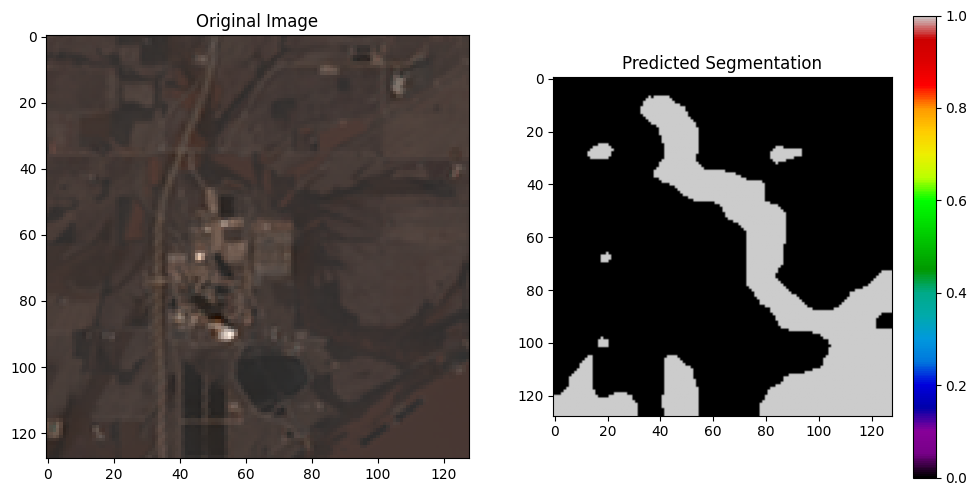

Saved prediction mask to pred_mask.png


In [43]:
import torch
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# ---- Load processor & trained model ----
processor = SegformerImageProcessor.from_pretrained("./final_model")
model = SegformerForSemanticSegmentation.from_pretrained("./final_model")
model.eval()

# ---- Load your test .tif image (bands 3-2-1 as RGB) ----
def load_tif_as_rgb(path):
    with rasterio.open(path) as src:
        img = np.stack([src.read(3), src.read(2), src.read(1)], axis=-1)  # bands 3-2-1
    img = (img - img.min()) / (img.max() - img.min()) * 255
    img = img.astype(np.uint8)
    return Image.fromarray(img)

img_path = r"E:\Cellula Tech\Computer Vision\Task 3\data\val\images\257.tif"
image = load_tif_as_rgb(img_path)

# ---- Preprocess ----
inputs = processor(images=image, return_tensors="pt")

# ---- Forward pass ----
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits  # (batch, num_classes, H/4, W/4)

# ---- Upsample to original size ----
upsampled_logits = torch.nn.functional.interpolate(
    logits,
    size=image.size[::-1],  # (height, width)
    mode="bilinear",
    align_corners=False
)

pred_seg = upsampled_logits.argmax(dim=1)[0].cpu().numpy()

# ---- Debug: check predicted classes ----
print("Unique predicted values:", np.unique(pred_seg))

# ---- Visualization ----
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Original Image")
plt.imshow(image)

plt.subplot(1,2,2)
plt.title("Predicted Segmentation")
plt.imshow(pred_seg, cmap="nipy_spectral", vmin=0, vmax=model.config.num_labels-1)
plt.colorbar()
plt.show()

# ---- Save output mask ----
out_path = "pred_mask.png"
Image.fromarray(pred_seg.astype(np.uint8)).save(out_path)
print(f"Saved prediction mask to {out_path}")
